Team Members:
Aniket Sarrin 
ghanshyam S Nair
MMV Sai Nikhil


In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import os
from datetime import datetime 
from functools import reduce
from operator import add
import pandas as pd
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline 

**Linear Rigression using Pyspark LinearRegression**

In [2]:
def predict(df):
    t_df =  df.sort('Date_value', ascending=False).limit(20)
    t_df = t_df.sort('Date_value')
    vectorAssembler = VectorAssembler(inputCols = ['Date_value'], outputCol = 'features')
    train_df = vectorAssembler.transform(t_df).limit(18)
    train_df = train_df.select(['features', 'Cases'])
    
    lr = LinearRegression(featuresCol = 'features', labelCol='Cases', maxIter=10, regParam=0.3, elasticNetParam=0.8)

    # Fit the model
    lrModel = lr.fit(train_df)

    # Print the coefficients and intercept for linear regression
    print("Coefficients: %s" % str(lrModel.coefficients))
    print("Intercept: %s" % str(lrModel.intercept))

    # Summarize the model over the training set and print out some metrics
    trainingSummary = lrModel.summary
    print("numIterations: %d" % trainingSummary.totalIterations)
    print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
    trainingSummary.residuals.show()
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)
    
    test_df = vectorAssembler.transform(t_df.sort('Date_Value', ascending=False)).limit(2)
    test_df.show()
    lr_predictions = lrModel.transform(test_df.select(col("features")))
    lr_predictions.show()
    
    print("Difference in 3/22/20: " + str(test_df.select(col("Cases")).collect()[1][0] - lr_predictions.select(col("prediction")).collect()[1][0]))
    print("Difference in 3/23/20: " + str(test_df.select(col("Cases")).collect()[0][0] - lr_predictions.select(col("prediction")).collect()[0][0]))
    print()
    print()

**Filter data to find only country with different countries**

In [3]:
def filterData1(df1):
      return df1.filter(col("Country/Region") == "Australia")

In [4]:
def filterData2(df2):
      return df2.filter(col("Country/Region") == "US")

**Transpose data**

In [5]:
def t_data(df):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("Date"), col(c).alias("Cases")) for c in cols
    ])).alias("kvs")

    return df.select([kvs]).select(["kvs.Date", "kvs.Cases"])

**Filter column**

In [6]:
def filter_province(province):
    return df.filter(col("Province/State") == province)

**Relative path**

In [8]:
#dirname = 'pydataset/'
filepath = 'hdfs://127.0.0.1:9000/pydataset/time_series_19-covid-Confirmed_archived_0325.csv'

**Read file**

In [9]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.option("inferSchema", "true").option("header", "true").csv(filepath)

**Filter data to find only country with Australia and US**

In [10]:
df1 = filterData1(df)
df1.toPandas()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,112,134,171,210,267,307,353,436,533,533
1,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,49,57,71,94,121,121,121,229,296,296
2,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,46,61,68,78,94,144,184,221,221,221
3,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,19,20,29,29,37,42,50,67,100,100
4,From Diamond Princess,Australia,35.4437,139.6380,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,...,17,17,28,31,35,52,64,90,120,120
6,Tasmania,Australia,-41.4545,145.9707,0,0,0,0,0,0,...,5,6,7,7,10,10,10,16,22,22
7,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,1,1,1,1,1,1,3,3,3,3
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,1,1,2,2,3,4,6,9,19,19


In [11]:
df2 = filterData2(df)
df2.toPandas()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,572,643,904,1076,1014,1376,1524,1793,1996,1996.0
1,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,525,732,967,1706,2495,5365,8310,11710,15793,15793.0
2,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,340,426,557,698,751,952,1177,1364,1642,1642.0
3,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,138,164,197,218,218,328,413,525,646,646.0
4,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,47,47,47,47,49,49,49,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,3,5,5,5,5,5,14,21,23,23.0
245,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,3,3,3,5,12,14,15,27,27.0
246,Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,1,1,1,2,2,3,3,3,3,NaN
247,United States Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0


**Dropped columns which are outside the time range**

In [12]:
names = df1.schema.names
start_date = datetime.strptime("1/31/20", '%m/%d/%y')
end_date = datetime.strptime("3/24/20", '%m/%d/%y')
#len(names)
for column in names:
    if column != "Province/State" and column != "Country/Region" and column != "Lat" and column != "Long":
        col_name = datetime.strptime(column, '%m/%d/%y')
        if not(col_name > start_date and col_name < end_date):
            df = df1.drop(column)
    


df1.toPandas()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,112,134,171,210,267,307,353,436,533,533
1,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,49,57,71,94,121,121,121,229,296,296
2,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,46,61,68,78,94,144,184,221,221,221
3,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,19,20,29,29,37,42,50,67,100,100
4,From Diamond Princess,Australia,35.4437,139.6380,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,...,17,17,28,31,35,52,64,90,120,120
6,Tasmania,Australia,-41.4545,145.9707,0,0,0,0,0,0,...,5,6,7,7,10,10,10,16,22,22
7,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,1,1,1,1,1,1,3,3,3,3
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,1,1,2,2,3,4,6,9,19,19


In [13]:
names = df2.schema.names
start_date = datetime.strptime("1/31/20", '%m/%d/%y')
end_date = datetime.strptime("3/24/20", '%m/%d/%y')
#len(names)
for column in names:
    if column != "Province/State" and column != "Country/Region" and column != "Lat" and column != "Long":
        col_name = datetime.strptime(column, '%m/%d/%y')
        if not(col_name > start_date and col_name < end_date):
            df = df2.drop(column)
    


df2.toPandas()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,572,643,904,1076,1014,1376,1524,1793,1996,1996.0
1,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,525,732,967,1706,2495,5365,8310,11710,15793,15793.0
2,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,340,426,557,698,751,952,1177,1364,1642,1642.0
3,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,138,164,197,218,218,328,413,525,646,646.0
4,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,47,47,47,47,49,49,49,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,3,5,5,5,5,5,14,21,23,23.0
245,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,3,3,3,5,12,14,15,27,27.0
246,Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,1,1,1,2,2,3,3,3,3,NaN
247,United States Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0


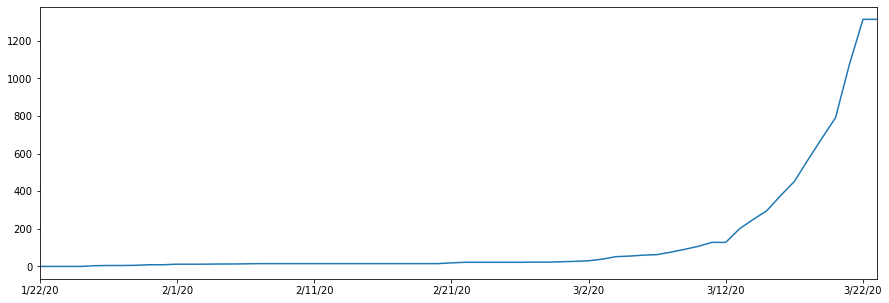

In [14]:
#df.describe().toPandas().transpose()
df1_plot = df1.drop(*["Province/State","Country/Region", "Lat", "Long"]).toPandas()
df1_plot.sum().plot(figsize=(15,5))


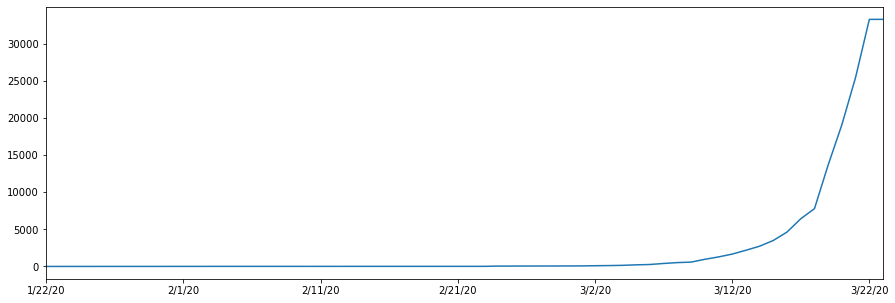

In [15]:
#df.describe().toPandas().transpose()
df2_plot = df2.drop(*["Province/State","Country/Region", "Lat", "Long"]).toPandas()
df2_plot.sum().plot(figsize=(15,5))


**Prediction for whole Australia**

In [57]:
df_australia = df1.drop(*["Province/State","Country/Region", "Lat", "Long"])
df_australia_t = t_data(df_australia.groupBy().sum())
df_australia_t = df_australia_t.select("*").withColumn("Date_value", monotonically_increasing_id()+1)
df_australia_t.show(5)
predict(df_australia_t)

+------------+-----+----------+
|        Date|Cases|Date_value|
+------------+-----+----------+
|sum(1/22/20)|    0|         1|
|sum(1/23/20)|    0|         2|
|sum(1/24/20)|    0|         3|
|sum(1/25/20)|    0|         4|
|sum(1/26/20)|    4|         5|
+------------+-----+----------+
only showing top 5 rows

Coefficients: [50.2684370878697]
Intercept: -2286.2133989141785
numIterations: 2
objectiveHistory: [0.4999999999999999, 0.41132067363171065, 0.09705662939312805]
+-------------------+
|          residuals|
+-------------------+
| 176.67060413578156|
| 129.40216704791146|
|  84.13372996004182|
| 36.865292872172176|
|-0.4031442156974663|
| -35.67158130356711|
| -69.94001839143675|
|  -99.2084554793064|
|-149.47689256717604|
|-127.74532965504568|
|-128.01376674291578|
|-131.28220383078542|
|-101.55064091865506|
|  -76.8190780065247|
|-11.087515094394348|
|  51.64404781773601|
| 111.37561072986637|
| 341.10717364199627|
+-------------------+

RMSE: 127.464294
r2: 0.807536
+---------

In [58]:
df_us = df2.drop(*["Province/State","Country/Region", "Lat", "Long"])
df_us_t = t_data(df_us.groupBy().sum())
df_us_t = df_us_t.select("*").withColumn("Date_value", monotonically_increasing_id()+1)
df_us_t.show(5)
predict(df_us_t)

+------------+-----+----------+
|        Date|Cases|Date_value|
+------------+-----+----------+
|sum(1/22/20)|    1|         1|
|sum(1/23/20)|    1|         2|
|sum(1/24/20)|    2|         3|
|sum(1/25/20)|    2|         4|
|sum(1/26/20)|    5|         5|
+------------+-----+----------+
only showing top 5 rows

Coefficients: [1102.766827922766]
Intercept: -51706.88052691134
numIterations: 3
objectiveHistory: [0.49999999999999994, 0.4200791551110208, 0.23174307085338464, 0.16896437610083767]
+-------------------+
|          residuals|
+-------------------+
|  4436.906926232405|
|  3402.140098309639|
| 2344.3732703868736|
|  1381.606442464108|
|  394.8396145413426|
| -642.9272133814229|
|-1369.6940413041884|
| -2150.460869226954|
|-2871.2276971497195|
| -3457.994525072485|
|-4012.7613529952505|
| -4343.528180918016|
|-4313.2950088407815|
|-3627.0618367635543|
|  -3367.82866468632|
| 1423.4045073909147|
|  5743.637679468149|
| 11029.870851545384|
+-------------------+

RMSE: 4087.116968
r

**Prediction for individual Province in Australia**

In [61]:

for row in df1.collect():
    df1_state = filter_province(row["Province/State"])
    df1_state = df1_state.drop(*["Province/State","Country/Region", "Lat", "Long"])
    df1_state_t = t_data(df1_state)
    df1_state_t = df1_state_t.select("*").withColumn("Date_value", monotonically_increasing_id()+1)
    print("Prediction for Province/State: " + row["Province/State"])
    predict(df1_state_t)
    


Prediction for Province/State: New South Wales
Coefficients: [21.88019584605882]
Intercept: -771.8614609447745
numIterations: 2
objectiveHistory: [0.5, 0.4094703210047335, 0.08028668903793099]
+-------------------+
|          residuals|
+-------------------+
|  71.81499802483347|
|  49.93480217877459|
|  32.05460633271582|
| 12.174410486656939|
|0.29421464059817026|
|-11.585981205460712|
| -26.46617705151948|
| -38.34637289757836|
| -60.22656874363713|
| -55.10676458969601|
| -56.98696043575478|
|-56.867156281813664|
| -41.74735212787243|
|-24.627547973931314|
| 10.492256180009917|
|  28.61206033395115|
|  52.73186448789238|
| 113.85166864183338|
+-------------------+

RMSE: 49.045413
r2: 0.843381
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|  533|        52|  [52.0]|
|3/22/20|  533|        51|  [51.0]|
+-------+-----+----------+--------+

+--------+------------------+
|features|        prediction|
+--------+------

+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|    3|        52|  [52.0]|
|3/22/20|    3|        51|  [51.0]|
+-------+-----+----------+--------+

+--------+------------------+
|features|        prediction|
+--------+------------------+
|  [52.0]|1.5973169520531412|
|  [51.0]|1.5404296232861754|
+--------+------------------+

Difference in 3/22/20: 1.4595703767138246
Difference in 3/23/20: 1.4026830479468588


Prediction for Province/State: Australian Capital Territory
Coefficients: [0.3264837659778905]
Intercept: -11.937965176971346
numIterations: 2
objectiveHistory: [0.49999999999999994, 0.4384691192416912, 0.2510351188129972]
+--------------------+
|           residuals|
+--------------------+
|  1.1640008997009588|
|  0.8375171337230682|
|  0.5110333677451777|
| 0.18454960176728719|
|-0.14193416421060334|
|-0.46841793018849387|
| -0.7949016961663844|
|  -1.121385462144275|
| -1.4478692281221655|
|  -0.77435299410

**Prediction for individual Province in US**

In [62]:

for row in df2.collect():
    df_state = filter_province(row["Province/State"])
    df_state = df_state.drop(*["Province/State","Country/Region", "Lat", "Long"])
    df_state_t = t_data(df_state)
    df_state_t = df_state_t.select("*").withColumn("Date_value", monotonically_increasing_id()+1)
    print("Prediction for Province/State: " + row["Province/State"])
    predict(df_state_t)
    


Prediction for Province/State: Washington
Coefficients: [104.19342480865171]
Intercept: -3738.193796225713
numIterations: 3
objectiveHistory: [0.5000000000000002, 0.40485611589189846, 0.13135829077955358, 0.04019234907543849]
+-------------------+
|          residuals|
+-------------------+
| 299.81077754020635|
| 195.61735273155455|
|   91.4239279229032|
|-12.769496885748595|
|-116.96292169440039|
| -221.1563465030522|
| -58.34977131170399|
| -63.54319612035533|
| -91.73662092900713|
| -69.93004573765893|
|-170.12347054631073|
|-203.31689535496253|
|-46.510320163614324|
| 21.296255027733878|
|-144.89716978091792|
| 112.90940541043028|
|  156.7159806017794|
|  321.5225557931276|
+-------------------+

RMSE: 158.918152
r2: 0.920530
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20| 1996|        52|  [52.0]|
|3/22/20| 1996|        51|  [51.0]|
+-------+-----+----------+--------+

+--------+------------------+
|features|  

Difference in 3/22/20: 260.8725047626217
Difference in 3/23/20: 236.62516608266378


Prediction for Province/State: Colorado
Coefficients: [21.661517731271594]
Intercept: -792.8974302922156
numIterations: 2
objectiveHistory: [0.5, 0.4104160315065532, 0.08849796694933003]
+-------------------+
|          residuals|
+-------------------+
|  78.06734516025301|
|  56.40582742898141|
|  34.74430969770981|
| 13.082791966438208|
| -8.578725764833393|
|-30.240243496104995|
|-36.901761227376596|
|  -39.5632789586482|
|-50.224796689919685|
| -67.88631442119129|
| -37.54783215246289|
| -29.20934988373449|
| -21.87086761500609|
| -43.53238534627769|
|-41.193903077549294|
|  30.14457919117922|
|   94.4830614599075|
|  99.82154372863602|
+-------------------+

RMSE: 51.550433
r2: 0.826916
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|  476|        52|  [52.0]|
|3/22/20|  476|        51|  [51.0]|
+-------+-----+----------+--------

Difference in 3/22/20: 256.858352746406
Difference in 3/23/20: 238.7966588834546


Prediction for Province/State: Iowa
Coefficients: [3.197232674704099]
Intercept: -114.85182266688679
numIterations: 2
objectiveHistory: [0.4999999999999999, 0.41218968510455445, 0.09606709529647535]
+--------------------+
|           residuals|
+--------------------+
|   9.343144401651529|
|   6.145911726947432|
|  2.9486790522433353|
|-0.24855362246077561|
| -3.4457862971648723|
|  -6.643018971868969|
| -1.8402516465730656|
|-0.03748432127716228|
|-0.23471699598127316|
| -2.4319496706853556|
| -5.6291823453894665|
|  -7.826415020093549|
|   -6.02364769479766|
|   -9.22088036950177|
|  -6.418113044205853|
|   5.384654281090036|
|  3.1874216063859535|
|  22.990188931681843|
+--------------------+

RMSE: 7.536313
r2: 0.833781
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|   90|        52|  [52.0]|
|3/22/20|   90|        51|  [51.0]|
+--

Difference in 3/22/20: 89.08560978228141
Difference in 3/23/20: 84.59169736170284


Prediction for Province/State: Indiana
Coefficients: [5.315801108027839]
Intercept: -195.77241264982197
numIterations: 2
objectiveHistory: [0.5, 0.42015831786995217, 0.16509826212050865]
+-------------------+
|          residuals|
+-------------------+
| 20.350976084903294|
| 15.035174976875453|
|  9.719373868847612|
|   4.40357276081977|
| -0.912228347208071|
| -6.228029455235884|
| -5.543830563263725|
| -5.859631671291567|
| -9.175432779319408|
| -14.49123388734725|
| -16.80703499537509|
|-18.122836103402932|
|-18.438637211430773|
|-18.754438319458615|
|-15.070239427486456|
| 0.6139594644857027|
|  21.29815835645789|
|  57.98235724843002|
+-------------------+

RMSE: 19.000922
r2: 0.682630
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|  201|        52|  [52.0]|
|3/22/20|  201|        51|  [51.0]|
+-------+-----+----------+--------+

Difference in 3/22/20: 16.692365485206423
Difference in 3/23/20: 14.420216822830483


Prediction for Province/State: Ohio
Coefficients: [10.781209738905792]
Intercept: -401.25353749792373
numIterations: 2
objectiveHistory: [0.5, 0.4197266702285686, 0.16400742979742694]
+-------------------+
|          residuals|
+-------------------+
|  45.47361611403261|
|  34.69240637512678|
| 23.911196636221007|
| 13.129986897315234|
|  2.348777158409405|
| -8.432432580496368|
| -16.21364231940214|
| -25.99485205830797|
| -35.77606179721374|
|-38.557271536119515|
|-36.338481275025345|
| -36.11969101393112|
| -33.90090075283689|
| -27.68211049174272|
|-19.463320230648492|
| 2.7554700304457356|
|  45.97426029153996|
| 110.19305055263408|
+-------------------+

RMSE: 38.715934
r2: 0.678337
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|  355|        52|  [52.0]|
|3/22/20|  355|        51|  [51.0]|
+-------+-----+----------+--------+


Difference in 3/22/20: 95.6696151593942
Difference in 3/23/20: 89.56466236915503


Prediction for Province/State: Kansas
Coefficients: [2.5944685409642423]
Intercept: -96.2260000055716
numIterations: 2
objectiveHistory: [0.5000000000000002, 0.4209415350413667, 0.16657985326418198]
+-------------------+
|          residuals|
+-------------------+
|  10.60853815375161|
|  8.014069612787367|
|  5.419601071823124|
| 2.8251325308588804|
| 0.2306639898946372|
| -2.363804551069606|
| -3.958273092033849|
| -6.552741632998092|
| -9.147210173962321|
|-7.7416787149265645|
| -7.336147255890808|
|  -9.93061579685505|
| -9.525084337819294|
| -5.119552878783537|
|  -7.71402141974778|
| 5.6915100392879765|
| 13.097041498323733|
| 23.502572957359504|
+-------------------+

RMSE: 9.150434
r2: 0.692948
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|   64|        52|  [52.0]|
|3/22/20|   64|        51|  [51.0]|
+-------+-----+----------

Difference in 3/22/20: 16.366671518292804
Difference in 3/23/20: 14.16550243834702


Prediction for Province/State: Idaho
Coefficients: [1.3260810470719455]
Intercept: -49.47680789793018
numIterations: 2
objectiveHistory: [0.5, 0.43043216916698157, 0.2304441684081785]
+-------------------+
|          residuals|
+-------------------+
|  5.716133344555978|
|  4.390052297484033|
|  3.063971250412088|
|  1.737890203340143|
|0.41180915626819825|
|-0.9142718908037537|
|-2.2403529378756986|
|-3.5664339849476434|
| -4.892515032019588|
| -5.218596079091533|
| -5.544677126163478|
| -3.870758173235423|
| -5.196839220307368|
|-3.5229202673793125|
|-3.8490013144512574|
|-3.1750823615232022|
|  7.498836591404846|
| 19.172755544332908|
+-------------------+

RMSE: 6.092513
r2: 0.579906
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|   42|        52|  [52.0]|
|3/22/20|   42|        51|  [51.0]|
+-------+-----+----------+--------+

+

Difference in 3/22/20: 13.313412386111892
Difference in 3/23/20: 12.22944409926987


Prediction for Province/State: South Dakota
Coefficients: [0.9021862012207608]
Intercept: -31.162949572883793
numIterations: 2
objectiveHistory: [0.5000000000000002, 0.41525429117762935, 0.10084449355710559]
+--------------------+
|           residuals|
+--------------------+
|  1.3908049325986873|
|   0.488618731377926|
| -0.4135674698428353|
|  -1.315753671063593|
|  -2.217939872284358|
| -3.1201260735051157|
| -4.0223122747258735|
|  3.0755015240533616|
|   2.173315322832604|
|   1.271129121611839|
|  1.3689429203910812|
| 0.46675671917031636|
|  0.5645705179495586|
|  0.6623843167288008|
|-0.23980188449196405|
| -1.1419880857127218|
|  0.9558257130665133|
| 0.05363951184575555|
+--------------------+

RMSE: 1.761219
r2: 0.888245
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|   21|        52|  [52.0]|
|3/22/20|   21|        51|  

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'